In [ ]:
import boto3
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
from CancerClassification.config.configuration import configManager
from CancerClassification.constants import *

In [2]:
c = configManager()
config = c.get_data_preparation_config()
print(config)

DataPreparationConfig(s3_bucket='multi-cancer-mlops-prasoon', s3_data_key='Data', class_structure='Multi Cancer/Multi Cancer/', split_ratio=0.09, local_splits_dir='/Users/pparashar21/Desktop/Projects/CancerDetectionMLOps/Artifacts/train_test_splits/')


In [3]:
def get_class_names(bucket_name, root_key):
    s3 = boto3.client("s3")
    classes_name = []

    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=root_key, Delimiter="/")

    if "CommonPrefixes" in response:
        for folder in response['CommonPrefixes']:
            top_level_folder = folder['Prefix'].split("/")[-2]
            if top_level_folder!="ALL":
                inner_prefix = folder["Prefix"]
                inner_response = s3.list_objects_v2(Bucket = bucket_name, Prefix = inner_prefix, Delimiter= "/")
                if "CommonPrefixes" in inner_response:
                    for subfolder in inner_response["CommonPrefixes"]:
                        class_name = subfolder["Prefix"].split("/")[-2]
                        classes_name.append(class_name)

    return classes_name

In [4]:
ROOT_DATA_FOLDER = os.path.join(config.s3_data_key, "Multi Cancer/Multi Cancer/")
class_names = get_class_names(config.s3_bucket, ROOT_DATA_FOLDER)
class_names

['brain_glioma',
 'brain_menin',
 'brain_tumor',
 'breast_benign',
 'breast_malignant',
 'cervix_dyk',
 'cervix_koc',
 'cervix_mep',
 'cervix_pab',
 'cervix_sfi',
 'kidney_normal',
 'kidney_tumor',
 'colon_aca',
 'colon_bnt',
 'lung_aca',
 'lung_bnt',
 'lung_scc',
 'lymph_cll',
 'lymph_fl',
 'lymph_mcl',
 'oral_normal',
 'oral_scc']

In [5]:
len(class_names)

22

In [6]:
from sklearn.model_selection import train_test_split

def get_image_paths_from_s3(bucket_name, root_prefix, split=0.09):
    s3 = boto3.client("s3")
    paginator = s3.get_paginator("list_objects_v2")
    operation_parameters = {
        "Bucket": bucket_name,
        "Prefix": root_prefix
    }

    image_paths = []

    for page in paginator.paginate(**operation_parameters):
        for obj in page.get("Contents", []):
            key = obj["Key"]
            if key.endswith("/"):
                continue
            parts = key[len(root_prefix):].split("/")  
            if len(parts) >= 3 and parts[0] != "ALL":
                image_paths.append(f"s3://{bucket_name}/{key}")

    split_count = int(len(image_paths) * split)
    train, valid = train_test_split(image_paths, test_size=split_count, random_state=42)
    train, test = train_test_split(train, test_size=split_count, random_state=42)
    return train, valid, test

In [7]:
train, valid, test = get_image_paths_from_s3(config.s3_bucket, ROOT_DATA_FOLDER, split=config.split_ratio)

In [8]:
train[0:5]

['s3://multi-cancer-mlops-prasoon/Data/Multi Cancer/Multi Cancer/Lymphoma/lymph_fl/lymph_fl_3903.jpg',
 's3://multi-cancer-mlops-prasoon/Data/Multi Cancer/Multi Cancer/Lung and Colon Cancer/lung_bnt/lung_bnt_4813.jpg',
 's3://multi-cancer-mlops-prasoon/Data/Multi Cancer/Multi Cancer/Lung and Colon Cancer/colon_aca/colon_aca_3583.jpg',
 's3://multi-cancer-mlops-prasoon/Data/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_3563.jpg',
 's3://multi-cancer-mlops-prasoon/Data/Multi Cancer/Multi Cancer/Cervical Cancer/cervix_pab/cervix_pab_0886.jpg']

In [9]:
print(f"Train: {len(train)} - Valid: {len(valid)} - Test: {len(test)}")

Train: 90202 - Valid: 9900 - Test: 9900


In [10]:
import numpy as np
import cv2
from io import BytesIO
from patchify import patchify

In [11]:
def process_image_label(s3_path, hp):
    # Parse bucket and key
    s3_path = s3_path.decode() if isinstance(s3_path, bytes) else s3_path
    assert s3_path.startswith("s3://"), "Path must be an S3 URI."

    s3 = boto3.client("s3")
    _, _, bucket, *key_parts = s3_path.split("/")
    key = "/".join(key_parts)

    # Download and read image into OpenCV
    response = s3.get_object(Bucket=bucket, Key=key)
    image_bytes = response["Body"].read()
    image_array = np.frombuffer(image_bytes, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Preprocess
    image = cv2.resize(image, (hp["IMAGE_SIZE"], hp["IMAGE_SIZE"]))
    image = image / 255.0

    patch_shape = (hp["PATCH_SIZE"], hp["PATCH_SIZE"], hp["NUM_CHANNELS"])
    patches = patchify(image, patch_shape, step=hp["PATCH_SIZE"])
    patches = np.reshape(patches, hp["FLAT_PATCHES_SHAPE"]).astype(np.float32)

    # Extract class from path
    class_name = key_parts[-2]  # Assuming structure: .../<class_name>/<image>
    class_idx = hp["CLASS_NAMES"].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)

    return patches, class_idx

In [12]:
import yaml

path = PARAMS_FILE_PATH
def load_hp(path):
    with open(path, 'r') as f:
        hp = yaml.safe_load(f)

    # Dynamically compute the derived values
    hp["NUM_PATCHES"] = (hp["IMAGE_SIZE"] ** 2) // (hp["PATCH_SIZE"] ** 2)
    hp["FLAT_PATCHES_SHAPE"] = (
        hp["NUM_PATCHES"],
        hp["PATCH_SIZE"] * hp["PATCH_SIZE"] * hp["NUM_CHANNELS"]
    )
    hp["CLASS_NAMES"] = get_class_names(bucket_name=config.s3_bucket, root_key=ROOT_DATA_FOLDER)
    return hp

hp = load_hp(path)


In [13]:
hp

{'IMAGE_SIZE': 512,
 'NUM_CHANNELS': 3,
 'PATCH_SIZE': 64,
 'BATCH_SIZE': 32,
 'LEARNING_RATE': '1e-4',
 'EPOCHS': 30,
 'NUM_CLASSES': 22,
 'NUM_LAYERS': 12,
 'HIDDEN_DIM': 512,
 'MLP_DIM': 3072,
 'NUM_HEADS': 12,
 'DROPOUT_RATE': 0.1,
 'NUM_PATCHES': 64,
 'FLAT_PATCHES_SHAPE': (64, 12288),
 'CLASS_NAMES': ['brain_glioma',
  'brain_menin',
  'brain_tumor',
  'breast_benign',
  'breast_malignant',
  'cervix_dyk',
  'cervix_koc',
  'cervix_mep',
  'cervix_pab',
  'cervix_sfi',
  'kidney_normal',
  'kidney_tumor',
  'colon_aca',
  'colon_bnt',
  'lung_aca',
  'lung_bnt',
  'lung_scc',
  'lymph_cll',
  'lymph_fl',
  'lymph_mcl',
  'oral_normal',
  'oral_scc']}

In [14]:
img = process_image_label(train[2], hp)

In [15]:
import tensorflow as tf

def parse_s3_with_hp(hp):
    """
    Parses an S3 image path into patches and a one-hot encoded label using TensorFlow.
    Args:
        path (tf.Tensor): A tf.string tensor containing the S3 URI (e.g. "s3://bucket/class_name/image.jpg")
    Returns:
        patches (tf.Tensor): Flattened image patches of shape `hp['flat_patches_shape']`
        label (tf.Tensor): One-hot encoded label of shape `[num_classes]`
    """
    def parse(path):
        patches, label = tf.numpy_function(
            func=lambda p: process_image_label(p, hp),
            inp=[path],
            Tout=[tf.float32, tf.int32]
        )

        label = tf.one_hot(label, depth=hp["NUM_CLASSES"])
        patches.set_shape(hp["FLAT_PATCHES_SHAPE"])
        label.set_shape([hp["NUM_CLASSES"]])
        return patches, label
    return parse

In [16]:
def tf_dataset(images, batch_size=32):
    """
    Creates a TensorFlow dataset pipeline from a list of S3 image paths.

    Args:
        images (list or tf.Tensor): List of S3 image paths
        batch_size (int): Batch size for training

    Returns:
        tf.data.Dataset: Batched, prefetched dataset yielding (patches, labels)
    """
    parse_fn = parse_s3_with_hp(hp)
    ds = tf.data.Dataset.from_tensor_slices(images)
    ds = ds.map(parse_fn, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [17]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

def visualise_patches(patches, patch_size=64, num_channels=3):
    """
    Visualise the first 64 patches from a single image (flattened patches).
    
    Args:
        patches: np.ndarray of shape (num_patches, patch_dim)
        patch_size: size of patch along one dimension
        num_channels: typically 3 for RGB
    """
    num_patches = patches.shape[0]
    assert num_patches >= 64, "Need at least 64 patches to visualise a full 8x8 grid"

    # Reshape flattened patches to (patch_size, patch_size, num_channels)
    reshaped_patches = patches[:64].reshape((-1, patch_size, patch_size, num_channels))

    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(8, 8)

    for i in range(64):
        ax = plt.subplot(gs[i])
        ax.imshow(reshaped_patches[i])
        ax.axis("off")

    plt.tight_layout()
    plt.show()

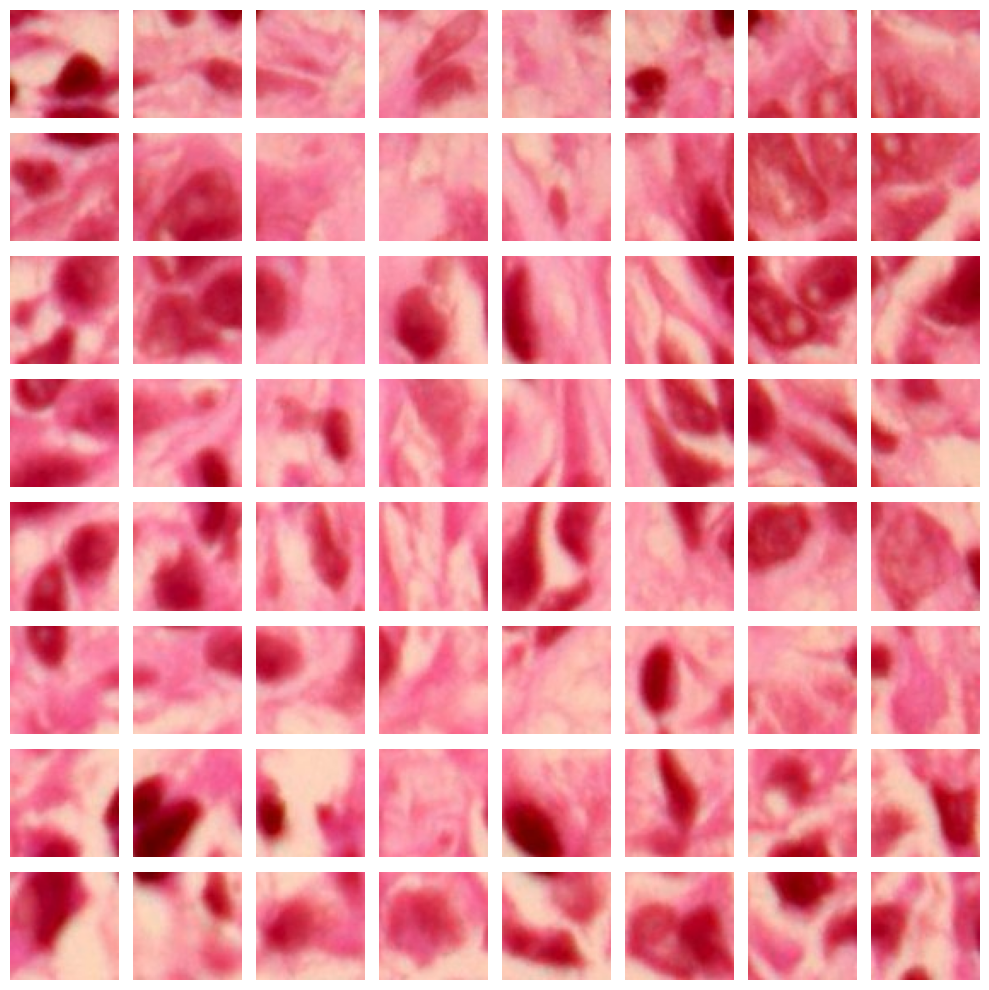

In [18]:
patches, label = process_image_label(train[169], hp)
visualise_patches(patches, patch_size=hp["PATCH_SIZE"], num_channels=hp["NUM_CHANNELS"])

In [19]:
label

array(14, dtype=int32)

In [20]:
train_ds = tf_dataset(train, batch_size=hp['BATCH_SIZE'])
valid_ds = tf_dataset(valid, batch_size=hp['BATCH_SIZE'])
test_ds = tf_dataset(test, batch_size=hp['BATCH_SIZE'])

In [21]:
for i, j in train_ds:
    print(i.shape, j.shape)
    break

(32, 64, 12288) (32, 22)


In [22]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset